## Rent Scrape Project

This notebook works through training and testing a model to detect when an apartment is a good deal.

To do this we train the model to predict the lowest price

### Import

In [3]:
#Packages needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Read in our data
model_data = pd.read_csv(r'C:\Users\jogoz\Rent_Scrape_Final.csv')

print(tf.__version__)

2.8.0


### Data Cleaning

In this stage we clean our data up and get it into a form that can be modeled.

In [4]:
#Seperate or date variable so we can one hot encode easier
model_data['Day_Recorded'] = pd.to_datetime(model_data['Day_Recorded'])
model_data['Day_Recorded_Weekday'] = model_data['Day_Recorded'].dt.day_name()
model_data['Day_Recorded_Month'] = model_data['Day_Recorded'].dt.month_name()

#One hot encode
dummy_vars = pd.get_dummies(model_data, columns=['City', 'Day_Recorded_Weekday', 'Day_Recorded_Month'])

#Select rows that have the lowest price for that apartment ID
lowest_price_df = dummy_vars.loc[dummy_vars.groupby(['unique_id'])['min_price'].idxmin()].reset_index(drop=True)

#Drop columns that aren't needed
data = lowest_price_df.drop(['Price', 'Move_in_date', 'Amenity','URL', 'building_id', 'unit_id',
       'Special_offer', 'Day_Recorded','unique_id',
       'month_discount', 'move_in_discount', 'Total_Cost', 'min_price', 'min_price_delta', 'Apartment Name',
       'Address', 'Floor', 'City_Washington DC', 'Day_Recorded_Weekday_Friday',
       'Day_Recorded_Month_December'], axis=1)

## Data Preparation

Train test split and normalization

In [6]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('true_monthly_cost')
test_labels = test_features.pop('true_monthly_cost')


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

[[1.2839087e+01 1.2351195e+00 1.3384188e+00 8.2311859e+02 6.6506915e-02
  2.3729563e+01 4.3191779e-02 1.3400512e-02 6.9771311e-03 1.5897889e-01
  1.4851333e-01 4.9393669e-02 3.6491513e-02 1.8683201e-01 1.9070810e-01
  1.5393993e-02 9.1422625e-02 1.2907706e-01 5.5429455e-02 2.1025532e-01
  2.2088723e-01 2.7011463e-01 4.2471889e-01 1.0576440e-02]]


### Model Building

In [15]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


In [18]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 24)               49        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                1600      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,874
Trainable params: 5,825
Non-trainable params: 49
_________________________________________________________________


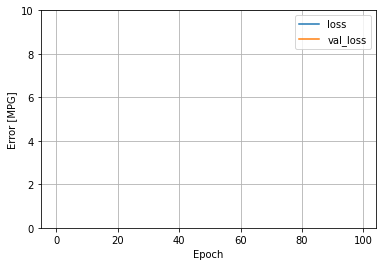

In [19]:
plot_loss(history)
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [21]:
pd.DataFrame(test_results, index=['Mean absolute error [True Monthly Cost]']).T


,Mean absolute error [True Monthly Cost]
dnn_model,358.312531


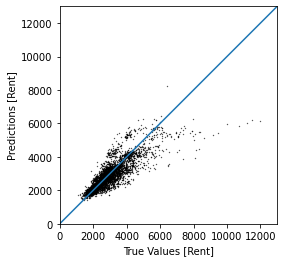

In [28]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)


plt.plot(test_labels, test_predictions, 'o', color='black',  markersize=.3)
plt.xlabel('True Values [Rent]')
plt.ylabel('Predictions [Rent]')
lims = [0, 13000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)